<a href="https://colab.research.google.com/github/AmbiTyga/Task-Stylumia/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Kaggle Download
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c stumbleupon

Saving kaggle.json to kaggle.json
  0% 0.00/3.45M [00:00<?, ?B/s]
100% 3.45M/3.45M [00:00<00:00, 56.9MB/s]
  0% 0.00/21.5k [00:00<?, ?B/s]
100% 21.5k/21.5k [00:00<00:00, 22.8MB/s]
 62% 5.00M/8.02M [00:00<00:00, 6.48MB/s]
100% 8.02M/8.02M [00:00<00:00, 9.71MB/s]
 95% 150M/157M [00:03<00:00, 61.8MB/s]
100% 157M/157M [00:03<00:00, 48.1MB/s]


In [2]:
!unzip -q /content/raw_content.zip

In [3]:
!git clone https://github.com/misja/python-boilerpipe.git
%cd python-boilerpipe
!pip install -r requirements.txt -q
!python setup.py install -q
%cd ..

Cloning into 'python-boilerpipe'...
remote: Enumerating objects: 264, done.
remote: Total 264 (delta 0), reused 0 (delta 0), pack-reused 264
Receiving objects: 100% (264/264), 30.06 KiB | 809.00 KiB/s, done.
Resolving deltas: 100% (91/91), done.
/content/python-boilerpipe
     |████████████████████████████████| 460kB 5.7MB/s 
/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'install_requires'
  warnings.warn(msg)
running install
running build
running build_py
creating build
creating build/lib
creating build/lib/boilerpipe
copying src/boilerpipe/__init__.py -> build/lib/boilerpipe
creating build/lib/boilerpipe/extract
copying src/boilerpipe/extract/__init__.py -> build/lib/boilerpipe/extract
creating build/lib/boilerpipe/data
creating build/lib/boilerpipe/data/boilerpipe-1.2.0
copying src/boilerpipe/data/boilerpipe-1.2.0/boilerpipe-1.2.0.jar -> build/lib/boilerpipe/data/boilerpipe-1.2.0
creating build/lib/boilerpipe/data/boilerpipe-1.2.0/lib
copying sr

In [1]:
import pandas as pd 
import numpy as np
import json
from bs4 import BeautifulSoup
import re, operator
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from boilerpipe.extract import Extractor
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder

## Preprocessing Functions

In [2]:
def extract_domain(df_url):
    # extract domains
    domain = df_url.str.lower().apply(lambda x:x.split('/')[2])
    domain_parts = domain.str.split('.')

    return domain_parts.apply(lambda x:'.'.join(x[-2:]) if x[-2] not in ['com', 'co'] else '.'.join(x[-3:]))

In [3]:
def clean_string(s):
  s = re.sub(r'[\r\n\t]', ' ',s)
  s = re.sub(r"\s+", ' ', s)
  return s.strip()

In [4]:
def boil_soup(urlid):
    filename = '/content/raw_content/' + urlid

    with open(filename, 'rb') as f:
        html = f.read()

        for parser in ["lxml", "xml", "html5lib"]:
            soup = BeautifulSoup(html, parser)
            if soup.body:
                return soup

        return BeautifulSoup(html)

In [5]:
def get_title(id):
  
  TAGS_REMOVE = ['script', 'style']
  
  soup = boil_soup(id)


  for el in soup.find_all(TAGS_REMOVE):
    el.extract()
  
  texts = soup.find_all('title')
  texts = [clean_string(x.text) for x in texts]

  try:
    return texts[np.argmax([len(x.split()) for x in texts])]
  except ValueError:
    return np.nan

In [70]:
def padding(text,attr = 'title'):
  max_len = 39 if attr=='title' else 282
  sent_len = len(text.split())
  if sent_len>max_len:
    return " ".join(text.split()[:max_len])
  else:
    text = " ".join(text.split()+['<pad>']*(max_len-sent_len))
    return text

In [11]:
def get_boiled(id):
  with open('/content/raw_content/'+id,'rb') as f:
    h = f.read()
  
  try:
    extractor = Extractor(extractor='ArticleExtractor', html = h)
  except:
    extractor = Extractor(extractor='ArticleExtractor', html = h.decode('iso-8859-1'))
  return str(extractor.getText())

## Dataset

In [8]:
data = pd.concat([pd.read_csv('/content/train.tsv.zip',sep = '\t'),
                  pd.read_csv('/content/test.tsv.zip',sep = '\t')],ignore_index = True)

In [51]:
item[features] = data[features].copy()

## Feature Extraction

In [10]:
item['real_url'] = item['url'].str.lower()
item['domain'] = extract_domain(item['real_url'])
item['tld'] = item['domain'].str.split('.').apply(lambda x:x[-1])

In [12]:
item['body'] = item['urlid'].astype(str).apply(get_boiled)
item.rename(columns = {'url':'org_url'},inplace = True)

item.drop(columns = ['boilerplate'],inplace = True)

In [13]:
item['title'] = item['urlid'].astype(str).apply(get_title)

In [52]:
item['alchemy_category_score'].replace('?','0.0',inplace = True)
item['alchemy_category_score'] = item['alchemy_category_score'].apply(float)

In [53]:
item['is_news'].replace('?','0',inplace = True)
item['is_news'] = item['is_news'].apply(int)

In [54]:
item['alchemy_category_score'] = item['alchemy_category_score'].replace('?',0).astype(float)
item['alchemy_category'].replace('?','',inplace = True)

In [55]:
le = LabelEncoder()
item['alchemy_labels'] = le.fit_transform(item['alchemy_category'])

In [56]:
leTLD = LabelEncoder()
item['tld_labels'] = le.fit_transform(item['tld'])

In [57]:
features = ['alchemy_category_score',
'avglinksize',
'commonlinkratio_1','commonlinkratio_2','commonlinkratio_3','commonlinkratio_4','compression_ratio',
'embed_ratio', 'frameTagRatio', 'html_ratio', 'image_ratio', 'is_news', 'lengthyLinkDomain',
'linkwordscore', 'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
'parametrizedLinkRatio', 'spelling_errors_ratio', 'alchemy_labels','tld_labels']

In [25]:
item['title'].fillna('',inplace = True)
item['body'].fillna('',inplace = True)

In [58]:
from sklearn.preprocessing import RobustScaler

In [69]:
scaler = Normalizer()
item[features] = scaler.fit_transform(item[features].values)

In [73]:
final = item[['alchemy_category_score','avglinksize',
              'commonlinkratio_1','commonlinkratio_2','commonlinkratio_3','commonlinkratio_4','compression_ratio',
              'embed_ratio', 'frameTagRatio', 'html_ratio', 'image_ratio', 'is_news', 'lengthyLinkDomain',
              'linkwordscore', 'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
              'parametrizedLinkRatio', 'spelling_errors_ratio', 'alchemy_labels','tld_labels',
              'alchemy_category','title','body','label']].copy()

In [ ]:
del final

In [ ]:
final = pd.concat([pd.read_json('/content/train_parsed.json'),
                   pd.read_json('/content/test_parsed.json')],ignore_index = True)

In [ ]:
final['title'].replace('','NULL',inplace = True)

In [27]:
item['title'] = item['title'].apply(lambda text:re.sub(r'[\W_]+',' ', text))
item['body'] = item['body'].apply(lambda text:re.sub(r'[\W_]+',' ', text))

item['body'] = item['body'].str.replace(r'[½]','half')
item['body'] = item['body'].str.replace('[¼]','quarter')

pattern = re.compile(r'[^a-zA-Z0-9\d\s:]')
item['body'] = item['body'].str.replace(pattern,' ')
item['alchemy_category'] = item['alchemy_category'].str.replace(pattern,' ')

spacer = re.compile(r'^\s+|\s+$')
item['title'] = item['title'].apply(lambda x:spacer.sub('',x))
item['body'] = item['body'].apply(lambda x:spacer.sub('',x))

item['title'] = item['title'].apply(clean_string)
item['body'] = item['body'].apply(clean_string)

In [30]:
test.query("body=='' and title==''")

,org_url,urlid,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,real_url,domain,tld,body,title,alchemy_labels
7577,http://borderlinemag.com/borderline01a.php?sec...,9057,recreation,0.000731,0.038981,0.000000,0.0,0.0,0.0,0.204652,-0.009745,0,0.002436,0,0.004683,-0.009745,0.0,0.0,0.974534,0,0.000000,0.009745,0.019491,0.009745,0.003898,NaN,http://borderlinemag.com/borderline01a.php?sec...,borderlinemag.com,com,,,0.077963
7888,http://mingmakescupcakes.yolasite.com/,4292,recreation,0.000913,0.035430,0.002577,0.0,0.0,0.0,0.141718,-0.012883,0,0.000773,0,0.003265,-0.012883,0.0,0.0,0.669941,0,0.708591,0.128835,0.000000,0.000000,0.012883,NaN,http://mingmakescupcakes.yolasite.com/,yolasite.com,com,,,0.103068
8408,http://urbansavior.com/wp-content/uploads/2011...,9331,,0.000000,0.039061,0.000000,0.0,0.0,0.0,0.205072,-0.009765,0,0.002441,1,0.004641,-0.009765,0.0,0.0,0.976535,?,0.000000,0.009765,0.048827,0.009765,0.002441,NaN,http://urbansavior.com/wp-content/uploads/2011...,urbansavior.com,com,,,0.000000
8587,http://www.icookgreek.com/index.asp?a_id=46,1857,,0.000000,0.048222,0.000000,0.0,0.0,0.0,0.253168,-0.012056,0,0.001507,0,0.008184,-0.012056,0.0,0.0,0.964448,?,0.048222,0.012056,0.024111,0.000000,0.003014,NaN,http://www.icookgreek.com/index.asp?a_id=46,icookgreek.com,com,,,0.000000


In [74]:
final['text'] = '<ac> ' + final['alchemy_category'] + ' <title> ' + final['title'].apply(padding)+ ' <body> ' + final['body'].apply(padding,attr='body') 

In [75]:
train = final.dropna(subset=['label']).reset_index(drop = True)
test = final[item['label'].isna()].drop(columns = ['label']).reset_index(drop = True)

In [77]:
from sklearn.model_selection import train_test_split
Train,val = train_test_split(train,test_size = 0.2,stratify = train['label'],random_state = 2021)

In [81]:
Train.to_csv("/content/train_parsed.csv",index=False)
val.reset_index(drop=True).to_csv("/content/val_parsed.csv",index=False)
test.to_csv("/content/test_parsed.csv",index=False)

In [84]:
!7z a TrainTest.7z test_parsed.csv train_parsed.csv val_parsed.csv


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive:
  0M Scan           3 files, 55911757 bytes (54 MiB)

Creating archive: TrainTest.7z

Items to compress: 3

  0%      2% + test_parsed.csv                        3% + test_parsed.csv                        5% + test_parsed.csv                        6% + test_parsed.csv                        7% + test_parsed.csv                        8% + test_parsed.csv                        9% + test_parsed.csv                       10% + test_parsed.csv

# Exploration

In [86]:
train.corr()

,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,frameTagRatio,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,alchemy_labels,tld_labels,label
alchemy_category_score,1.000000,0.161287,0.317494,0.233315,0.131352,0.086577,0.470981,-0.483037,0.452553,0.540951,-0.104151,0.473958,0.083386,0.501314,-0.488599,0.209661,0.506669,0.335362,0.553880,0.758461,0.586492,-0.109530
avglinksize,0.161287,1.000000,0.279188,0.260828,0.313549,0.308017,0.149891,-0.136789,0.085526,0.143381,-0.054458,0.104104,0.114773,0.281496,-0.333111,0.123163,0.149777,0.107499,0.159614,0.132628,0.154901,-0.017106
commonlinkratio_1,0.317494,0.279188,1.000000,0.764869,0.539650,0.337023,0.406592,-0.367310,0.162450,0.291735,-0.128404,0.402597,0.329837,0.653818,-0.392774,0.432652,0.469498,0.141881,0.331405,0.325051,0.373004,-0.131879
commonlinkratio_2,0.233315,0.260828,0.764869,1.000000,0.659217,0.433438,0.260928,-0.239741,0.096954,0.165267,-0.090431,0.235077,0.323026,0.395747,-0.240636,0.338277,0.299518,0.080898,0.235302,0.239195,0.209536,-0.091562
commonlinkratio_3,0.131352,0.313549,0.539650,0.659217,1.000000,0.736795,0.230465,-0.214682,0.066928,0.101324,-0.100384,0.262237,0.392948,0.335187,-0.203249,0.255686,0.263471,0.061773,0.172344,0.155001,0.170183,-0.057964
commonlinkratio_4,0.086577,0.308017,0.337023,0.433438,0.736795,1.000000,0.163839,-0.153210,0.050898,0.059003,-0.075776,0.182351,0.327775,0.231616,-0.155784,0.180018,0.162163,0.019242,0.100439,0.089868,0.114916,-0.044074
compression_ratio,0.470981,0.149891,0.406592,0.260928,0.230465,0.163839,1.000000,-0.976554,0.426003,0.524320,-0.557325,0.460921,0.045701,0.550374,-0.500381,0.129469,0.558625,0.459908,0.538087,0.498978,0.515055,-0.060412
embed_ratio,-0.483037,-0.136789,-0.367310,-0.239741,-0.214682,-0.153210,-0.976554,1.000000,-0.426268,-0.503734,0.591099,-0.494972,-0.040370,-0.497288,0.471031,-0.110120,-0.532050,-0.415273,-0.523965,-0.536353,-0.477203,0.051947
frameTagRatio,0.452553,0.085526,0.162450,0.096954,0.066928,0.050898,0.426003,-0.426268,1.000000,0.930080,-0.151479,0.362483,0.025811,0.322118,-0.510066,0.088453,0.404688,0.296558,0.710418,0.426124,0.745383,-0.069571
html_ratio,0.540951,0.143381,0.291735,0.165267,0.101324,0.059003,0.524320,-0.503734,0.930080,1.000000,-0.159427,0.383130,0.045466,0.497741,-0.628220,0.166038,0.504407,0.341749,0.778298,0.496792,0.832431,-0.092852


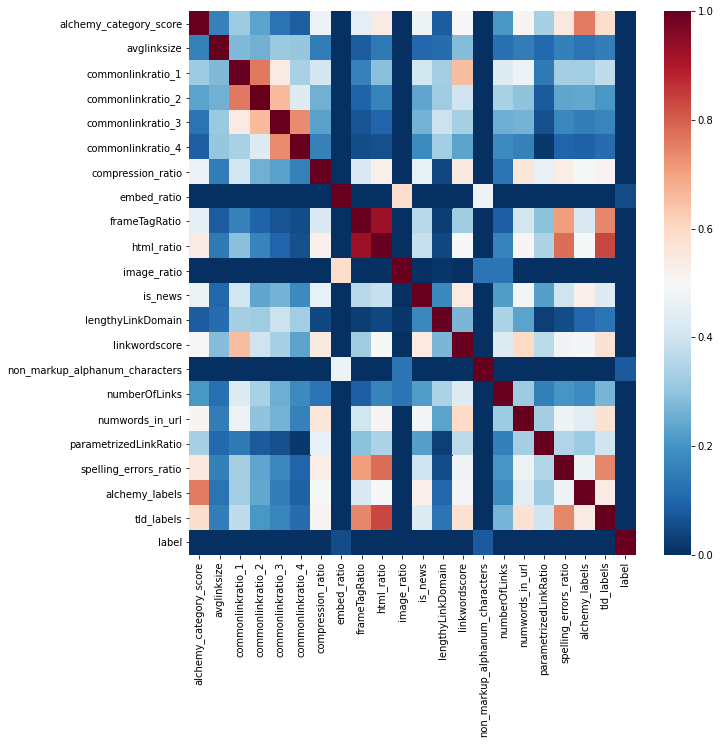

In [87]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),cmap='RdBu_r', vmin=0)
plt.show()

In [88]:
px.histogram(train, x='alchemy_category', color="label", barmode='group')

## Text EDA

In [89]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

download_file_from_google_drive('1KfiHaW7Ei31VSmi7gqfSdegTjHB8xuAm', '/content/glove.840B.300d.zip')

In [90]:
def load_embed(file):
  '''
  Loads GLoVe embeddings
  file -> path to glove embeddings
  load_embed(...) -> Dict()
  '''
  def get_coefs(word,*arr): 
      return word, np.asarray(arr, dtype='float32')
  
  embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='utf-8'))
      
  return embeddings_index

# Build vocab from dataset
def build_vocab(texts):
  '''
  Creates a vocabulary from the given corpus
  texts -> pandas Series object
  build_vocab(...) -> Dict()
  '''
  sentences = texts.str.split().values
  vocab = {}
  for sentence in sentences:
      for word in sentence:
          try:
              vocab[word] += 1
          except KeyError:
              vocab[word] = 1
  return vocab

# Checks how many words present in embeddings wrt dataset
def check_coverage(vocab, embeddings_index):
  '''
  Checks the vocabulary from the given corpus with GLoVE data
  Returns out of vocabulary words from corpus that are not present in GLoVE data
  '''
  known_words = {}
  unknown_words = {}
  nb_known_words = 0
  nb_unknown_words = 0
  for word in vocab.keys():
      try:
          known_words[word] = embeddings_index[word]
          nb_known_words += vocab[word]
      except:
          unknown_words[word] = vocab[word]
          nb_unknown_words += vocab[word]
          pass

  print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
  print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
  unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
  unknown_words = pd.DataFrame(unknown_words,columns=['Word','Count'])
  return unknown_words

In [92]:
!unzip /content/glove.840B.300d.zip
glove = load_embed("/content/glove.840B.300d.txt")

Archive:  /content/glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [93]:
final['raw_text'] = final['alchemy_category'] + ' ' + final['title'] + ' ' + final['body']

In [94]:
vocab = build_vocab(final['raw_text'])
oov_glove = check_coverage(vocab, glove)

Found embeddings for 84.381% of vocab
Found embeddings for  98.949% of all text


In [96]:
oov_glove.query("Count>100")

,Word,Count
0,RssHelper,6844
1,XmlHelper,5434
2,FormatHelper,4842
3,argSeparator,2002
4,ArticlesController,936
5,InsidersHealth,553
6,fashionshows,534
7,menrunway,434
8,insidershealth,399
9,stateprovince,306
